<a href="https://colab.research.google.com/github/Tsyhankova/goit_python/blob/main/HW_10_tensorflow_fashion_mnist_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, layers

In [78]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 200 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 512 # количество нейронов 1-го слоя
n_hidden_2 = 512 # количество нейронов 2-го слоя
n_hidden_3 = 384

In [79]:
from tensorflow.keras.datasets import fashion_mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [80]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [81]:
# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [82]:
class NN(Model):
    # Set layers.
    def __init__(self, name=None):
        super(NN, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # Second fully-connecter hidden layer.
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        self.fc3 = layers.Dense(n_hidden_3, activation=tf.nn.relu)
        self.fc4 = layers.Dropout(0.5)
        self.out = layers.Dense(num_classes, activation = tf.nn.softmax)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.out(x)
        return x

In [83]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.) 

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [84]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="fashion_mnist")

In [85]:
# Функция обучения нейросети
def train(neural_net, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
  trainable_variables = neural_net.trainable_variables

    # Вычислим по ним значение градиента
  gradients = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
  optimizer.apply_gradients(zip(gradients, trainable_variables))

In [86]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss.numpy())
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc.numpy())
        
print(accuracy_history)
print(loss_history)

[0.81, 0.77, 0.86, 0.875, 0.905, 0.885, 0.9, 0.86, 0.91, 0.915, 0.905, 0.94, 0.95, 0.895, 0.91, 0.9, 0.945, 0.91, 0.92, 0.895, 0.95, 0.94, 0.905, 0.93, 0.955, 0.955, 0.945, 0.955, 0.93, 0.94]
[91.94428, 154.68832, 85.67892, 69.29973, 58.000095, 62.43903, 53.74609, 71.674324, 49.07021, 61.849834, 50.616238, 44.335342, 38.372215, 61.507347, 57.777668, 60.209515, 34.32779, 45.090115, 45.35214, 50.539295, 37.760303, 25.56371, 48.04909, 32.460762, 28.972023, 30.075134, 36.534668, 27.970276, 42.433712, 31.751919]


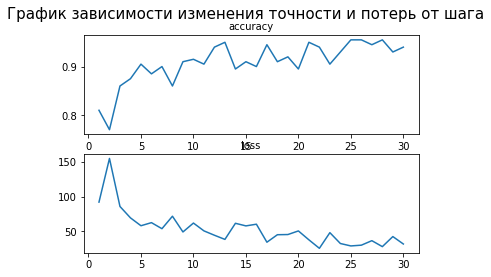

In [87]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

fig, axs = plt.subplots(2, 1)
step = np.arange(1,31)
axs[0].plot(step, accuracy_history, label='accuracy')
axs[1].plot(step, loss_history, label='loss')
axs[0].set_title('accuracy', fontsize=10)
axs[1].set_title('loss', fontsize=10)
fig.suptitle('График зависимости изменения точности и потерь от шага', fontsize=15)
plt.show()

In [88]:
# Вычислите точность обученной нейросети

pred = neural_net(x_test)
print("Accuracy: ", accuracy(pred, y_test).numpy())

Accuracy:  0.8806


In [89]:
pred = neural_net(x_train)
print("Accuracy: ", accuracy(pred, y_train).numpy())

Accuracy:  0.90995


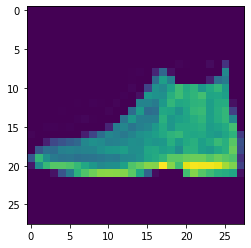

Ответ нейросети:  Ankle boot


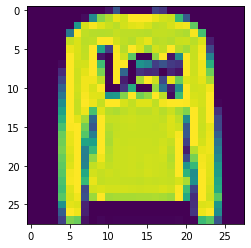

Ответ нейросети:  Pullover


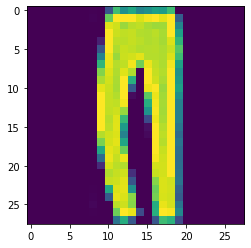

Ответ нейросети:  Trouser


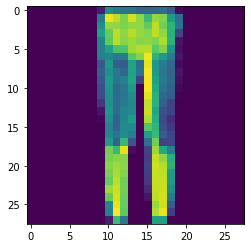

Ответ нейросети:  Trouser


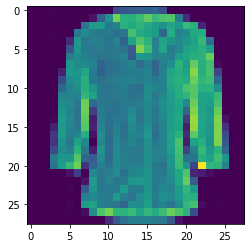

Ответ нейросети:  Shirt


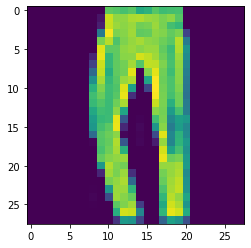

Ответ нейросети:  Trouser


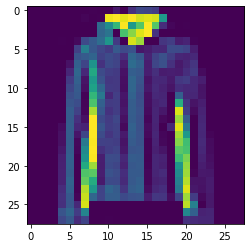

Ответ нейросети:  Coat


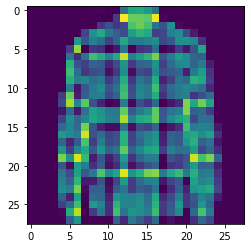

Ответ нейросети:  Shirt


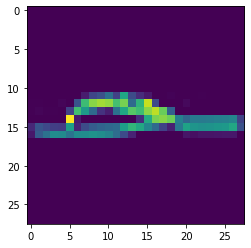

Ответ нейросети:  Sandal


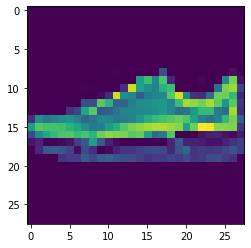

Ответ нейросети:  Sneaker


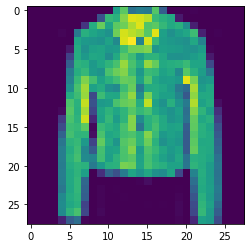

Ответ нейросети:  Coat


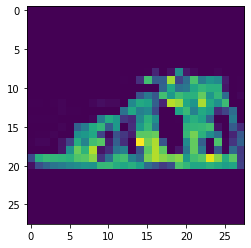

Ответ нейросети:  Sandal


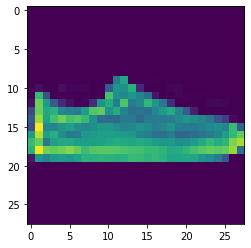

Ответ нейросети:  Sneaker


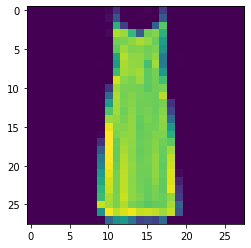

Ответ нейросети:  Dress


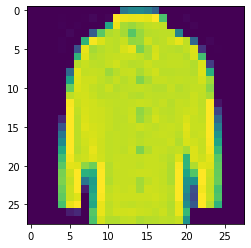

Ответ нейросети:  Coat


In [90]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

predictions = neural_net(x_test)

label_dictionnary = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 
                     3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 
                     7:'Sneaker', 8:'Bag', 9:'Ankle boot' }

for i in range(15):
    plt.imshow(np.reshape(x_test[i], [28, 28]))
    plt.show()
    print("Ответ нейросети: ", label_dictionnary[np.argmax(predictions.numpy()[i])])

На выбранной тестовой выборке из 15 изображений я вижу одну ошибку.
